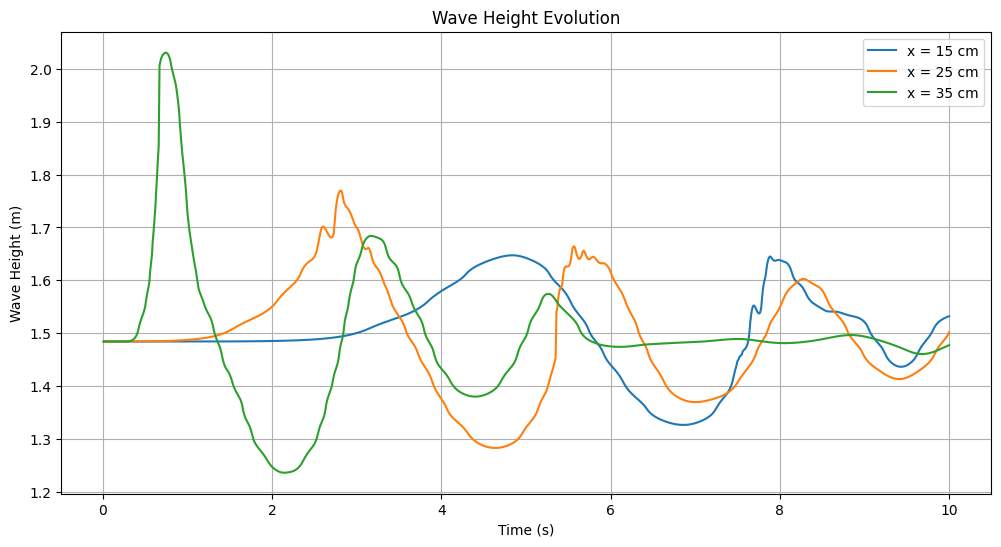

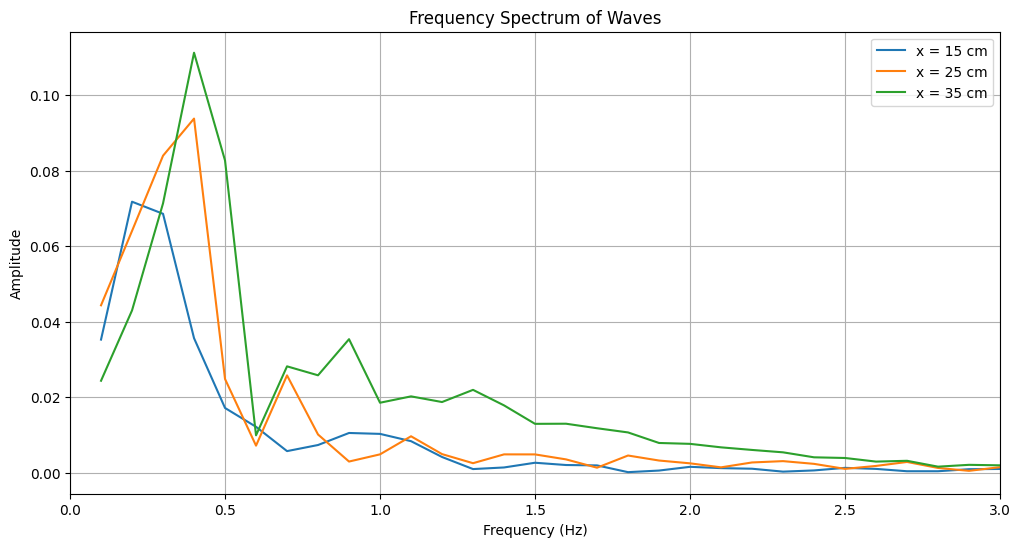

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
import os

# Function to read OpenFOAM data files
def read_probe_data(filename):
    data = np.loadtxt(filename, comments='#')
    time = data[:, 0]
    alpha = data[:, 1]
    return time, alpha

# Function to find interface height from alpha values
def find_interface_height(alpha_values, y_coords):
    # Find where alpha transitions from 1 to 0 (interface)
    for i in range(len(alpha_values)-1):
        if alpha_values[i] > 0.5 and alpha_values[i+1] < 0.5:
            # Linear interpolation for more accurate height
            h = y_coords[i] + (y_coords[i+1]-y_coords[i])*(0.5-alpha_values[i])/(alpha_values[i+1]-alpha_values[i])
            return h
    return None

# Directory containing the probe data
case_dir = "/Users/georgiiburdin/DataspellProjects/droplet_stationalSurface_impact/water"
probe_dir = os.path.join(case_dir, "postProcessing/waveMeasurement")

# Get list of time directories
time_dirs = sorted([d for d in os.listdir(probe_dir) if d != '0'], key=float)

# Arrays to store wave heights over time
times = []
heights = {f"probe{i}": [] for i in range(1, 4)}
y_coords = np.linspace(0, 8, 160)  # Based on your probe setup

# Read data from each time directory
for time_dir in time_dirs:
    t = float(time_dir)
    times.append(t)

    for i in range(1, 4):
        filename = os.path.join(probe_dir, time_dir, f"probe{i}_alpha.water.xy")
        _, alpha = read_probe_data(filename)
        height = find_interface_height(alpha, y_coords)
        if height is not None:
            heights[f"probe{i}"].append(height)
        else:
            heights[f"probe{i}"].append(3.0)  # Default pool height

# Convert to numpy arrays
times = np.array(times)
for probe in heights:
    heights[probe] = np.array(heights[probe])

# Plot wave heights over time
plt.figure(figsize=(12, 6))
probe_positions = [15, 25, 35]
for i, probe in enumerate(heights, 1):
    plt.plot(times, heights[probe], label=f'x = {probe_positions[i-1]} cm')

plt.xlabel('Time (s)')
plt.ylabel('Wave Height (m)')
plt.title('Wave Height Evolution')
plt.legend()
plt.grid(True)
plt.savefig('wave_heights.png')
plt.show()

# Perform FFT analysis
plt.figure(figsize=(12, 6))
for i, probe in enumerate(heights, 1):
    # Remove mean to focus on oscillations
    signal = heights[probe] - np.mean(heights[probe])

    # Compute FFT
    N = len(times)
    dt = times[1] - times[0]  # time step
    yf = fft(signal)
    xf = fftfreq(N, dt)

    # Plot only positive frequencies up to 5 Hz
    pos_freq_mask = xf > 0
    plt.plot(xf[pos_freq_mask], 2.0/N * np.abs(yf[pos_freq_mask]), label=f'x = {probe_positions[i-1]} cm')
    plt.xlim(0, 3)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('Frequency Spectrum of Waves')
plt.legend()
plt.grid(True)
plt.savefig('wave_spectrum.png')
plt.show()